In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-question-pairs/train.csv.zip
/kaggle/input/quora-question-pairs/sample_submission.csv.zip
/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/test.csv.zip


# **Credits**: The notebook has been made following this [tutorial](https://youtu.be/1fvQU5yPjFs) with a lot of value addition.

## Our goal is to create and deploy a model that predicts whether two questions are same or not. As Quora said while hosting the competition:

## "Currently, Quora uses a Random Forest model to identify duplicate questions. In this competition, Kagglers are challenged to tackle this natural language processing problem by applying advanced techniques to classify whether question pairs are duplicates or not. Doing so will make it easier to find high quality answers to questions resulting in an improved experience for Quora writers, seekers, and readers."

## Final deployed model will take two questions from user as input and predict whether these questions are duplicates or not.

[![image-2022-04-28-061503739.png](https://i.postimg.cc/WbMzBgcG/image-2022-04-28-061503739.png)](https://postimg.cc/QHdj5BtC)

# **For Live Demo click [here](https://duplicate-question-checker.herokuapp.com)**

---

# Necessary Imports 

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import re
import scipy
from bs4 import BeautifulSoup
import nltk
import spacy
import string
pd.options.mode.chained_assignment = None

In [3]:
df=pd.read_csv('/kaggle/input/quora-question-pairs/train.csv.zip')

In [4]:
df.shape

(404290, 6)

In [5]:
df = df.sample(90000)


In [6]:
df=df.dropna()

<AxesSubplot:xlabel='is_duplicate'>

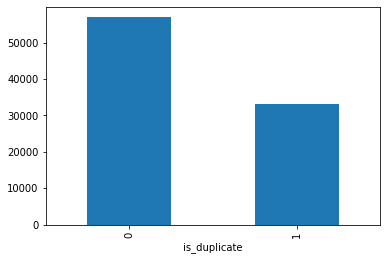

In [7]:
df.groupby("is_duplicate")['id'].count().plot.bar()

## The dataset is imbalanced, let's downsample non-duplicates to create a balanced dataset.

In [8]:
df

,id,qid1,qid2,question1,question2,is_duplicate
281603,281603,31868,12639,Why do people ask questions on Quora while The...,Why do people ask stupid questions on Quora th...,1
281106,281106,400823,400824,Where is the best area to stay with nightlife ...,What is the best town to stay in the Algarve a...,0
155271,155271,243287,243288,Why is sex a taboo?,Why is sex so taboo if everyone does it?,1
44737,44737,80258,80259,How would anyone convince his wife to reconcil...,How would anyone convince his wife to reconcil...,1
16836,16836,32059,32060,How does our diet affect our mental health?,How much does diet affect mental health?,1
...,...,...,...,...,...,...
279004,279004,398362,398363,Can I downgrade my Xperia z3 to 5.1.1 from 6.0.1?,How can I upgrade android 4.4.2 to 5.0.1?,0
359991,359991,137645,489712,Why doesn't my partner acknowledge any events ...,Why don't my friends seem interested in contac...,0
8910,8910,17341,17342,Why don't children love their parents as much ...,Is it true that children don't love their pare...,1
145103,145103,229498,229499,What are some examples of triple entendres?,What is the difference between a pun and a dou...,0


In [9]:
a=len(df[df['is_duplicate']!=0])

In [10]:
nonduplicate_df = df.loc[df['is_duplicate'] == 0][:a]
duplicate_df = df.loc[df['is_duplicate'] == 1]

normal_distributed_df = pd.concat([nonduplicate_df, duplicate_df])

# Shuffle dataframe rows
df = normal_distributed_df.sample(frac=1, random_state=42)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate
399664,399664,359863,344768,What is the worst place to live in india?,Where is the worst place to stay in India?,1
153538,153538,240976,240977,What are some good books that contain counting...,What are the best books about combinatorics?,0
331391,331391,157501,392508,What is the creepiest thing to ever happen to ...,What is the creepiest thing that ever happened...,1
48120,48120,77112,36390,How can the drive from Edmonton to Auckland be...,How can the drive from Edmonton to Auckland be...,1
359327,359327,21356,20949,How is first time sex experience?,How does it feel when a person has sex for the...,1


In [11]:
df['is_duplicate'].value_counts()

1    33048
0    33048
Name: is_duplicate, dtype: int64

<AxesSubplot:xlabel='is_duplicate'>

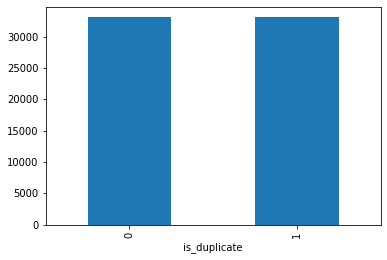

In [12]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [13]:
df['is_duplicate'].value_counts()

1    33048
0    33048
Name: is_duplicate, dtype: int64

# Let's extract some features before preprocessing the data

# Sentence Count

In [14]:
def count_sent1(text):
    return len(nltk.sent_tokenize(text['question1']))
df['count_sent1'] = df.apply(count_sent1, axis=1)

def count_sent2(text):
    return len(nltk.sent_tokenize(text['question2']))
df['count_sent2'] = df.apply(count_sent2, axis=1)

# Capital Characters in sentence

In [15]:
def count_capital_chars(text):
    count=0
    for i in text['question1']:
        if i.isupper():
            count+=1
    return count
df['count_capital_chars1'] = df.apply(count_capital_chars, axis=1)

def count_capital_chars(text):
    count=0
    for i in text['question2']:
        if i.isupper():
            count+=1
    return count
df['count_capital_chars2'] = df.apply(count_capital_chars, axis=1)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,count_sent1,count_sent2,count_capital_chars1,count_capital_chars2
399664,399664,359863,344768,What is the worst place to live in india?,Where is the worst place to stay in India?,1,1,1,1,2
153538,153538,240976,240977,What are some good books that contain counting...,What are the best books about combinatorics?,0,1,1,1,1
331391,331391,157501,392508,What is the creepiest thing to ever happen to ...,What is the creepiest thing that ever happened...,1,1,1,1,1
48120,48120,77112,36390,How can the drive from Edmonton to Auckland be...,How can the drive from Edmonton to Auckland be...,1,1,1,4,4
359327,359327,21356,20949,How is first time sex experience?,How does it feel when a person has sex for the...,1,1,1,1,1


# Number of Capital Words

In [16]:
def count_capital_words1(text):
    return sum(map(str.isupper,text['question1'].split()))
def count_capital_words2(text):
    return sum(map(str.isupper,text['question2'].split()))

df['count_capital_words1'] = df.apply(count_capital_words1, axis=1)
df['count_capital_words2'] = df.apply(count_capital_words2, axis=1)


In [17]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,count_sent1,count_sent2,count_capital_chars1,count_capital_chars2,count_capital_words1,count_capital_words2
399664,399664,359863,344768,What is the worst place to live in india?,Where is the worst place to stay in India?,1,1,1,1,2,0,0
153538,153538,240976,240977,What are some good books that contain counting...,What are the best books about combinatorics?,0,1,1,1,1,0,0
331391,331391,157501,392508,What is the creepiest thing to ever happen to ...,What is the creepiest thing that ever happened...,1,1,1,1,1,0,0
48120,48120,77112,36390,How can the drive from Edmonton to Auckland be...,How can the drive from Edmonton to Auckland be...,1,1,1,4,4,0,0
359327,359327,21356,20949,How is first time sex experience?,How does it feel when a person has sex for the...,1,1,1,1,1,0,0


# Preprocessing

In [18]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q
    

In [19]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:343: MarkupResemblesLocatorWarning: "." looks like a directory name, not markup. You may want to open a file found in this directory and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [20]:
ques_df = df[['question1','question2']]
ques_df.head()

,question1,question2
399664,what is the worst place to live in india,where is the worst place to stay in india
153538,what are some good books that contain counting...,what are the best books about combinatorics
331391,what is the creepiest thing to ever happen to you,what is the creepiest thing that ever happened...
48120,how can the drive from edmonton to auckland be...,how can the drive from edmonton to auckland be...
359327,how is first time sex experience,how does it feel when a person has sex for the...


In [21]:
ques_df = ques_df.dropna(subset=['question1','question2'])

In [22]:
ques_df

,question1,question2
399664,what is the worst place to live in india,where is the worst place to stay in india
153538,what are some good books that contain counting...,what are the best books about combinatorics
331391,what is the creepiest thing to ever happen to you,what is the creepiest thing that ever happened...
48120,how can the drive from edmonton to auckland be...,how can the drive from edmonton to auckland be...
359327,how is first time sex experience,how does it feel when a person has sex for the...
...,...,...
150476,what is the order of advent candles,what order should advent candles be lit
265152,can i upgrade the ram of macbook pro early 20...,can i upgrade anything about my early 2015 mac...
326071,how do you quit smoking,how to quit smoking
19264,i am 16 how can i get into an 18 concert,i want to get a motorbike but my parents do no...


# Feature Engineering

In [23]:
ques_df['q1_len'] = ques_df['question1'].str.len() 
ques_df['q2_len'] = ques_df['question2'].str.len()

In [24]:
ques_df['q1_num_words'] = ques_df['question1'].apply(lambda row: len(row.split(" ")))
ques_df['q2_num_words'] = ques_df['question2'].apply(lambda row: len(row.split(" ")))
ques_df.head()

,question1,question2,q1_len,q2_len,q1_num_words,q2_num_words
399664,what is the worst place to live in india,where is the worst place to stay in india,40,41,9,9
153538,what are some good books that contain counting...,what are the best books about combinatorics,72,43,11,7
331391,what is the creepiest thing to ever happen to you,what is the creepiest thing that ever happened...,49,53,10,10
48120,how can the drive from edmonton to auckland be...,how can the drive from edmonton to auckland be...,122,123,23,23
359327,how is first time sex experience,how does it feel when a person has sex for the...,32,62,6,14


## Token Features

In [25]:
# Advanced Features
from nltk.corpus import stopwords

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*9
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    #Last two words
    token_features[8] = int(q1_tokens[-1:-3] == q2_tokens[-1:-4])

    
    return token_features

In [26]:
token_features = ques_df.apply(fetch_token_features, axis=1)

ques_df["cwc_min"]       = list(map(lambda x: x[0], token_features))
ques_df["cwc_max"]       = list(map(lambda x: x[1], token_features))
ques_df["csc_min"]       = list(map(lambda x: x[2], token_features))
ques_df["csc_max"]       = list(map(lambda x: x[3], token_features))
ques_df["ctc_min"]       = list(map(lambda x: x[4], token_features))
ques_df["ctc_max"]       = list(map(lambda x: x[5], token_features))
ques_df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
ques_df["first_word_eq"] = list(map(lambda x: x[7], token_features))
ques_df["last_two_word_eq"] = list(map(lambda x: x[8], token_features))

## Fuzzy Features


[Theory behind fuzzy features](https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/)

In [27]:
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [28]:
fuzzy_features = ques_df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
ques_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
ques_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
ques_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
ques_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

## Common Words Features

In [29]:
stops = stopwords.words("english")

In [30]:
def common_words(row):

    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)


In [31]:
ques_df['word_common'] = ques_df.apply(common_words, axis=1)
ques_df.head()

,question1,question2,q1_len,q2_len,q1_num_words,q2_num_words,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,last_two_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,word_common
399664,what is the worst place to live in india,where is the worst place to stay in india,40,41,9,9,0.749981,0.749981,0.799984,0.799984,0.777769,0.777769,1.0,0.0,1.0,84,82,81,86,7
153538,what are some good books that contain counting...,what are the best books about combinatorics,72,43,11,7,0.666644,0.333328,0.499988,0.399992,0.571420,0.363633,1.0,1.0,1.0,63,63,54,79,4
331391,what is the creepiest thing to ever happen to you,what is the creepiest thing that ever happened...,49,53,10,10,0.749981,0.749981,0.999980,0.833319,0.799992,0.799992,1.0,1.0,1.0,94,90,90,93,8
48120,how can the drive from edmonton to auckland be...,how can the drive from edmonton to auckland be...,122,123,23,23,0.874989,0.874989,0.999991,0.999991,0.857139,0.857139,0.0,1.0,1.0,96,96,93,96,19
359327,how is first time sex experience,how does it feel when a person has sex for the...,32,62,6,14,0.749981,0.599988,0.499975,0.111110,0.666656,0.285712,0.0,1.0,1.0,43,53,53,72,4


## Total Words Features

In [32]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

In [33]:
ques_df['word_total'] = ques_df.apply(total_words, axis=1)
ques_df.head()

,question1,question2,q1_len,q2_len,q1_num_words,q2_num_words,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,last_two_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,word_common,word_total
399664,what is the worst place to live in india,where is the worst place to stay in india,40,41,9,9,0.749981,0.749981,0.799984,0.799984,...,0.777769,1.0,0.0,1.0,84,82,81,86,7,18
153538,what are some good books that contain counting...,what are the best books about combinatorics,72,43,11,7,0.666644,0.333328,0.499988,0.399992,...,0.363633,1.0,1.0,1.0,63,63,54,79,4,18
331391,what is the creepiest thing to ever happen to you,what is the creepiest thing that ever happened...,49,53,10,10,0.749981,0.749981,0.999980,0.833319,...,0.799992,1.0,1.0,1.0,94,90,90,93,8,19
48120,how can the drive from edmonton to auckland be...,how can the drive from edmonton to auckland be...,122,123,23,23,0.874989,0.874989,0.999991,0.999991,...,0.857139,0.0,1.0,1.0,96,96,93,96,19,40
359327,how is first time sex experience,how does it feel when a person has sex for the...,32,62,6,14,0.749981,0.599988,0.499975,0.111110,...,0.285712,0.0,1.0,1.0,43,53,53,72,4,20


## Shared Words

In [34]:
ques_df['word_share'] = round(ques_df['word_common']/ques_df['word_total'],2)
ques_df.head()

,question1,question2,q1_len,q2_len,q1_num_words,q2_num_words,cwc_min,cwc_max,csc_min,csc_max,...,last_word_eq,first_word_eq,last_two_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,word_common,word_total,word_share
399664,what is the worst place to live in india,where is the worst place to stay in india,40,41,9,9,0.749981,0.749981,0.799984,0.799984,...,1.0,0.0,1.0,84,82,81,86,7,18,0.39
153538,what are some good books that contain counting...,what are the best books about combinatorics,72,43,11,7,0.666644,0.333328,0.499988,0.399992,...,1.0,1.0,1.0,63,63,54,79,4,18,0.22
331391,what is the creepiest thing to ever happen to you,what is the creepiest thing that ever happened...,49,53,10,10,0.749981,0.749981,0.999980,0.833319,...,1.0,1.0,1.0,94,90,90,93,8,19,0.42
48120,how can the drive from edmonton to auckland be...,how can the drive from edmonton to auckland be...,122,123,23,23,0.874989,0.874989,0.999991,0.999991,...,0.0,1.0,1.0,96,96,93,96,19,40,0.48
359327,how is first time sex experience,how does it feel when a person has sex for the...,32,62,6,14,0.749981,0.599988,0.499975,0.111110,...,0.0,1.0,1.0,43,53,53,72,4,20,0.20


[](http://)

# Non Common Words

In [35]:
def non_common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))   
    return len(w1 | w2)
ques_df['non_common_words'] = (ques_df.apply(non_common_words, axis=1))-(ques_df['word_common'])
ques_df.head()

,question1,question2,q1_len,q2_len,q1_num_words,q2_num_words,cwc_min,cwc_max,csc_min,csc_max,...,first_word_eq,last_two_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,word_common,word_total,word_share,non_common_words
399664,what is the worst place to live in india,where is the worst place to stay in india,40,41,9,9,0.749981,0.749981,0.799984,0.799984,...,0.0,1.0,84,82,81,86,7,18,0.39,4
153538,what are some good books that contain counting...,what are the best books about combinatorics,72,43,11,7,0.666644,0.333328,0.499988,0.399992,...,1.0,1.0,63,63,54,79,4,18,0.22,10
331391,what is the creepiest thing to ever happen to you,what is the creepiest thing that ever happened...,49,53,10,10,0.749981,0.749981,0.999980,0.833319,...,1.0,1.0,94,90,90,93,8,19,0.42,3
48120,how can the drive from edmonton to auckland be...,how can the drive from edmonton to auckland be...,122,123,23,23,0.874989,0.874989,0.999991,0.999991,...,1.0,1.0,96,96,93,96,19,40,0.48,2
359327,how is first time sex experience,how does it feel when a person has sex for the...,32,62,6,14,0.749981,0.599988,0.499975,0.111110,...,1.0,1.0,43,53,53,72,4,20,0.20,12


# Both Questions Same

In [36]:
ques_df['exactly_same'] = (df['question1'] == df['question2'])


In [37]:
ques_df

,question1,question2,q1_len,q2_len,q1_num_words,q2_num_words,cwc_min,cwc_max,csc_min,csc_max,...,last_two_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,word_common,word_total,word_share,non_common_words,exactly_same
399664,what is the worst place to live in india,where is the worst place to stay in india,40,41,9,9,0.749981,0.749981,0.799984,0.799984,...,1.0,84,82,81,86,7,18,0.39,4,False
153538,what are some good books that contain counting...,what are the best books about combinatorics,72,43,11,7,0.666644,0.333328,0.499988,0.399992,...,1.0,63,63,54,79,4,18,0.22,10,False
331391,what is the creepiest thing to ever happen to you,what is the creepiest thing that ever happened...,49,53,10,10,0.749981,0.749981,0.999980,0.833319,...,1.0,94,90,90,93,8,19,0.42,3,False
48120,how can the drive from edmonton to auckland be...,how can the drive from edmonton to auckland be...,122,123,23,23,0.874989,0.874989,0.999991,0.999991,...,1.0,96,96,93,96,19,40,0.48,2,False
359327,how is first time sex experience,how does it feel when a person has sex for the...,32,62,6,14,0.749981,0.599988,0.499975,0.111110,...,1.0,43,53,53,72,4,20,0.20,12,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150476,what is the order of advent candles,what order should advent candles be lit,35,39,7,7,0.999967,0.749981,0.333322,0.249994,...,1.0,73,77,78,83,4,14,0.29,6,False
265152,can i upgrade the ram of macbook pro early 20...,can i upgrade anything about my early 2015 mac...,68,57,15,11,0.714276,0.624992,0.499988,0.399992,...,1.0,59,63,60,77,7,25,0.28,11,False
326071,how do you quit smoking,how to quit smoking,23,19,5,4,0.999950,0.999950,0.499975,0.333322,...,1.0,86,84,86,91,3,9,0.33,3,False
19264,i am 16 how can i get into an 18 concert,i want to get a motorbike but my parents do no...,42,81,13,23,0.499988,0.399992,0.333328,0.199998,...,1.0,41,50,39,48,5,27,0.19,17,False


In [38]:
final_df = ques_df.drop(columns=['question1','question2'])
print(final_df.shape)
final_df.head()

(66096, 22)


,q1_len,q2_len,q1_num_words,q2_num_words,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,...,last_two_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,word_common,word_total,word_share,non_common_words,exactly_same
399664,40,41,9,9,0.749981,0.749981,0.799984,0.799984,0.777769,0.777769,...,1.0,84,82,81,86,7,18,0.39,4,False
153538,72,43,11,7,0.666644,0.333328,0.499988,0.399992,0.571420,0.363633,...,1.0,63,63,54,79,4,18,0.22,10,False
331391,49,53,10,10,0.749981,0.749981,0.999980,0.833319,0.799992,0.799992,...,1.0,94,90,90,93,8,19,0.42,3,False
48120,122,123,23,23,0.874989,0.874989,0.999991,0.999991,0.857139,0.857139,...,1.0,96,96,93,96,19,40,0.48,2,False
359327,32,62,6,14,0.749981,0.599988,0.499975,0.111110,0.666656,0.285712,...,1.0,43,53,53,72,4,20,0.20,12,False


# Merge Features that we made before preprocessing

In [39]:
df

,id,qid1,qid2,question1,question2,is_duplicate,count_sent1,count_sent2,count_capital_chars1,count_capital_chars2,count_capital_words1,count_capital_words2
399664,399664,359863,344768,what is the worst place to live in india,where is the worst place to stay in india,1,1,1,1,2,0,0
153538,153538,240976,240977,what are some good books that contain counting...,what are the best books about combinatorics,0,1,1,1,1,0,0
331391,331391,157501,392508,what is the creepiest thing to ever happen to you,what is the creepiest thing that ever happened...,1,1,1,1,1,0,0
48120,48120,77112,36390,how can the drive from edmonton to auckland be...,how can the drive from edmonton to auckland be...,1,1,1,4,4,0,0
359327,359327,21356,20949,how is first time sex experience,how does it feel when a person has sex for the...,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
150476,150476,236830,236831,what is the order of advent candles,what order should advent candles be lit,1,1,1,2,2,0,0
265152,265152,382067,195439,can i upgrade the ram of macbook pro early 20...,can i upgrade anything about my early 2015 mac...,0,1,1,6,5,1,1
326071,326071,33032,86971,how do you quit smoking,how to quit smoking,1,1,1,1,0,0,0
19264,19264,36418,36419,i am 16 how can i get into an 18 concert,i want to get a motorbike but my parents do no...,0,1,2,2,3,1,2


In [40]:
df2 = df.drop(columns=['id','qid1','qid2','question1','question2'])
final_df = pd.concat([df2, final_df], axis=1)


In [41]:
ques_df=ques_df.dropna()

# Correlation between features

In [42]:
final_df.corr()

,is_duplicate,count_sent1,count_sent2,count_capital_chars1,count_capital_chars2,count_capital_words1,count_capital_words2,q1_len,q2_len,q1_num_words,...,last_two_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,word_common,word_total,word_share,non_common_words,exactly_same
is_duplicate,1.000000,-0.080894,-0.115198,-0.109397,-0.120152,-0.064064,-0.096489,-0.188475,-0.178486,-0.184141,...,0.009528,0.388270,0.363719,0.391301,0.422829,0.193921,-0.208301,0.380683,-0.382850,0.045734
count_sent1,-0.080894,1.000000,0.231942,0.239447,0.092837,0.226934,0.119198,0.439079,0.187169,0.506444,...,-0.001939,-0.160531,-0.112181,-0.129169,-0.099260,0.138684,0.364394,-0.090490,0.285948,0.019134
count_sent2,-0.115198,0.231942,1.000000,0.105711,0.305223,0.130513,0.323085,0.214034,0.530519,0.234738,...,-0.001138,-0.201542,-0.146302,-0.165909,-0.125285,0.147515,0.446404,-0.119321,0.368275,0.008520
count_capital_chars1,-0.109397,0.239447,0.105711,1.000000,0.490824,0.673686,0.322816,0.344379,0.192118,0.371359,...,0.007478,-0.145647,-0.133449,-0.120379,-0.114424,0.146708,0.323071,-0.080408,0.234447,-0.009812
count_capital_chars2,-0.120152,0.092837,0.305223,0.490824,1.000000,0.328813,0.694387,0.213444,0.375614,0.220222,...,0.001420,-0.160895,-0.143580,-0.134003,-0.119240,0.154380,0.360069,-0.087421,0.268627,-0.009514
count_capital_words1,-0.064064,0.226934,0.130513,0.673686,0.328813,1.000000,0.488907,0.210278,0.118393,0.304336,...,0.001143,-0.119623,-0.114288,-0.109493,-0.097770,0.096888,0.254173,-0.060556,0.199331,-0.007024
count_capital_words2,-0.096489,0.119198,0.323085,0.322816,0.694387,0.488907,1.000000,0.137409,0.288397,0.189118,...,0.003294,-0.155178,-0.143841,-0.141496,-0.122593,0.097130,0.311469,-0.088437,0.261610,-0.006593
q1_len,-0.188475,0.439079,0.214034,0.344379,0.213444,0.210278,0.137409,1.000000,0.514731,0.951983,...,0.013432,-0.262614,-0.241639,-0.208660,-0.223127,0.394000,0.818413,-0.170564,0.575956,-0.010884
q2_len,-0.178486,0.187169,0.530519,0.192118,0.375614,0.118393,0.288397,0.514731,1.000000,0.480599,...,0.006225,-0.266863,-0.240360,-0.212890,-0.207473,0.396172,0.844633,-0.165354,0.602801,-0.010779
q1_num_words,-0.184141,0.506444,0.234738,0.371359,0.220222,0.304336,0.189118,0.951983,0.480599,1.000000,...,0.010872,-0.275971,-0.251293,-0.222819,-0.224582,0.400379,0.830496,-0.165625,0.584008,-0.011209


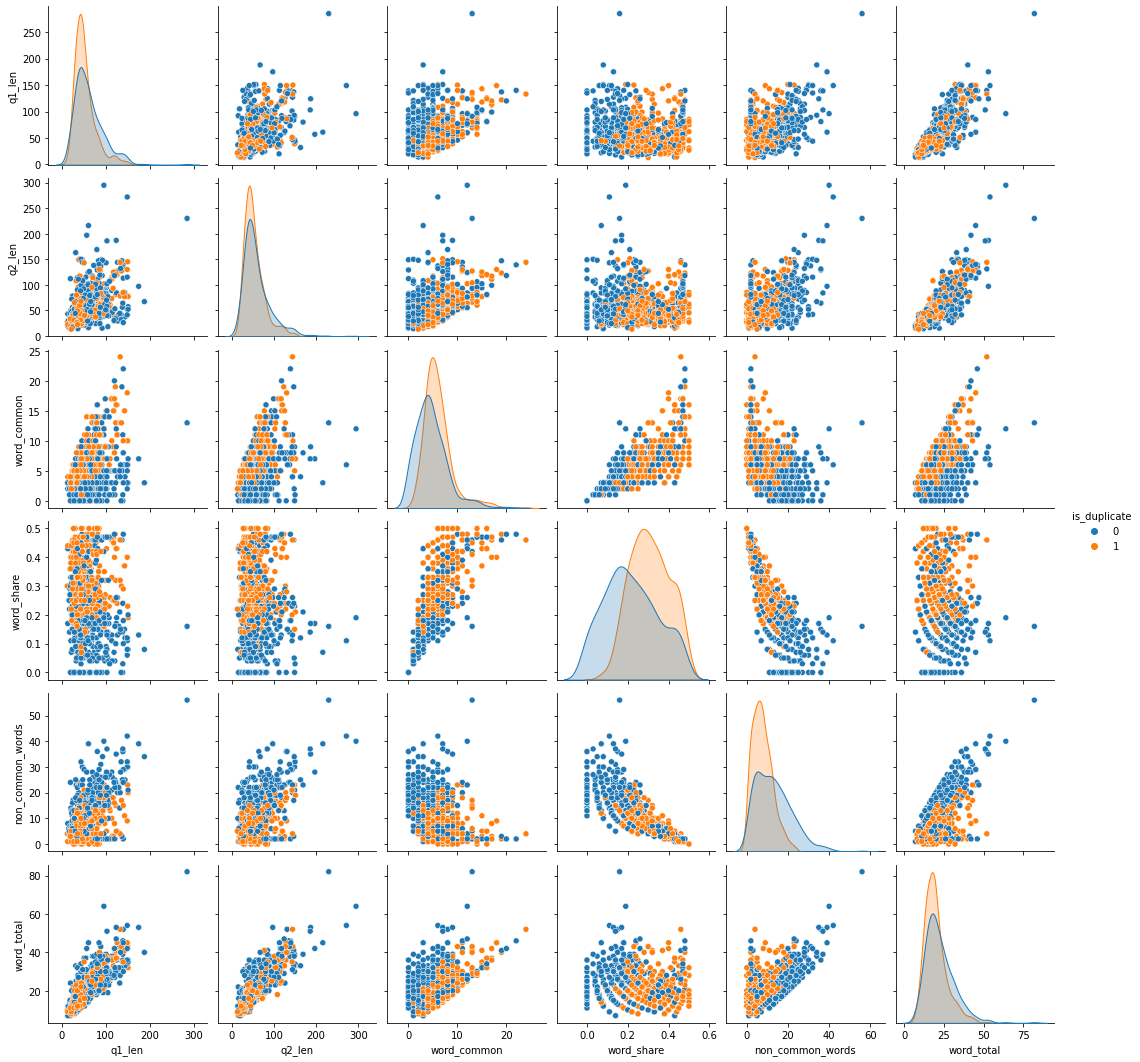

In [43]:
n = 1000
sns.pairplot(final_df[['q1_len', 'q2_len', 'word_common','word_share', 'non_common_words','word_total','is_duplicate']][0:n], hue='is_duplicate')
plt.show()

# Word Embeddings 

In [44]:
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])
cv = TfidfVectorizer(max_features=1000)

q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [45]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(66096, 2000)

In [46]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(66096, 2029)


,is_duplicate,count_sent1,count_sent2,count_capital_chars1,count_capital_chars2,count_capital_words1,count_capital_words2,q1_len,q2_len,q1_num_words,...,990,991,992,993,994,995,996,997,998,999
399664,1,1,1,1,2,0,0,40,41,9,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
153538,0,1,1,1,1,0,0,72,43,11,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
331391,1,1,1,1,1,0,0,49,53,10,...,0.0,0.0,0.0,0.0,0.0,0.262708,0.0,0.0,0.0,0.0
48120,1,1,1,4,4,0,0,122,123,23,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
359327,1,1,1,1,1,0,0,32,62,6,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [47]:
final_df.head()

,is_duplicate,count_sent1,count_sent2,count_capital_chars1,count_capital_chars2,count_capital_words1,count_capital_words2,q1_len,q2_len,q1_num_words,...,990,991,992,993,994,995,996,997,998,999
399664,1,1,1,1,2,0,0,40,41,9,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
153538,0,1,1,1,1,0,0,72,43,11,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
331391,1,1,1,1,1,0,0,49,53,10,...,0.0,0.0,0.0,0.0,0.0,0.262708,0.0,0.0,0.0,0.0
48120,1,1,1,4,4,0,0,122,123,23,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
359327,1,1,1,1,1,0,0,32,62,6,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


# Train/Test Split

In [48]:
X=final_df.drop(['is_duplicate'],axis=1)
y=final_df['is_duplicate']

In [49]:
X=X.values
y=y.values

In [50]:
X

array([[1, 1, 1, ..., 0.0, 0.0, 0.0],
       [1, 1, 1, ..., 0.0, 0.0, 0.0],
       [1, 1, 1, ..., 0.0, 0.0, 0.0],
       ...,
       [1, 1, 1, ..., 0.0, 0.0, 0.0],
       [1, 2, 2, ..., 0.0, 0.0, 0.0],
       [1, 1, 5, ..., 0.0, 0.0, 0.0]], dtype=object)

In [51]:
y

array([1, 0, 1, ..., 1, 0, 0])

In [52]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

# Modeling

In [53]:
# build the lightgbm model
import lightgbm as lgb
clf = lgb.LGBMClassifier(n_estimators=200)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [54]:
accuracy_score(y_test,y_pred)

0.8040847201210287

In [55]:
confusion_matrix(y_test,y_pred)


array([[4855, 1764],
       [ 826, 5775]])

In [56]:
# build the lightgbm model
import lightgbm as lgb
clf1 = lgb.LGBMClassifier()
clf1.fit(X_train, y_train)
y_pred = clf1.predict(X_test)


In [57]:
confusion_matrix(y_test,y_pred)


array([[4706, 1913],
       [ 779, 5822]])

In [58]:
accuracy_score(y_test,y_pred)

0.7963691376701967

In [59]:
# build the lightgbm model
import lightgbm as lgb
clf2 = lgb.LGBMClassifier(n_estimators=300)
clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)


In [60]:
confusion_matrix(y_test,y_pred)


array([[4908, 1711],
       [ 876, 5725]])

In [61]:
accuracy_score(y_test,y_pred)

0.8043116490166414

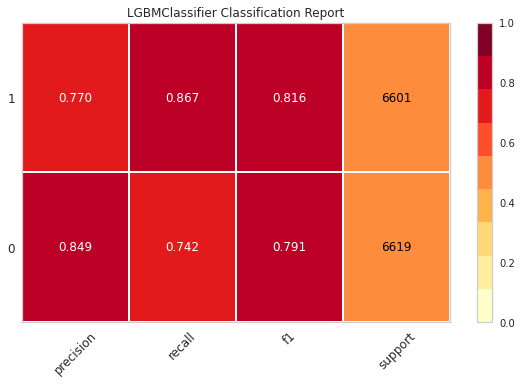

In [62]:
from yellowbrick.classifier import ClassificationReport
classes = [0, 1]
visualizer = ClassificationReport(clf2, classes=classes, support=True)
visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()             # Draw/show the data
plt.show()

In [63]:
# build the lightgbm model
import lightgbm as lgb
clf3 = lgb.LGBMClassifier(n_estimators=350)
clf3.fit(X_train, y_train)
y_pred = clf3.predict(X_test)

In [64]:
accuracy_score(y_test,y_pred)


0.804160363086233

In [65]:
confusion_matrix(y_test,y_pred)

array([[4912, 1707],
       [ 882, 5719]])

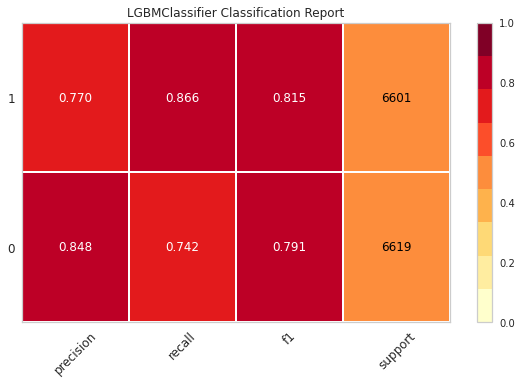

In [66]:
from yellowbrick.classifier import ClassificationReport
classes = [0, 1]
visualizer = ClassificationReport(clf3, classes=classes, support=True)
visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()             # Draw/show the data
plt.show()

# Ensembling

In [67]:
from sklearn.ensemble import VotingClassifier
model = VotingClassifier(estimators=[('clf', clf), ('clf1', clf1),('clf2',clf2),('clf3',clf3)], voting='soft')
model.fit(X_train,y_train)
y_pred=model.predict(X_test)


In [68]:
accuracy_score(y_test,y_pred)

0.8050680786686838

In [69]:
confusion_matrix(y_test,y_pred)


array([[4858, 1761],
       [ 816, 5785]])

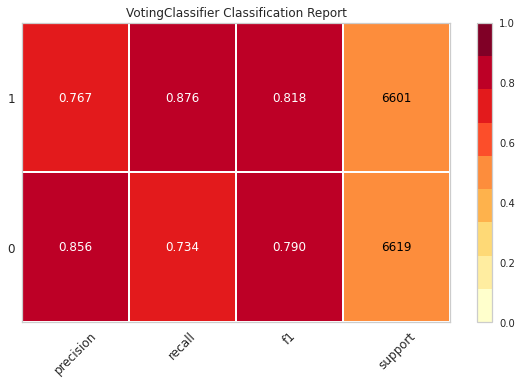

In [70]:
from yellowbrick.classifier import ClassificationReport
classes = [0, 1]
visualizer = ClassificationReport(model, classes=classes, support=True)
visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()             # Draw/show the data
plt.show()

# Let's create pickle files of ensembled model and word embeddings

In [71]:
import pickle

pickle.dump(model,open('model1.pkl','wb'))
pickle.dump(cv,open('cv1.pkl','wb'))

In [72]:
from IPython.display import FileLinks
FileLinks('.') # input argument is specified folder

./
  model1.pkl
  __notebook__.ipynb
  cv1.pkl

In [73]:
pd.set_option('display.max_rows', 200)


In [74]:

if [(df['question1'] == df['question2'])]:
    df['is_duplicate']=1

In [75]:
df[(df['question1'] == df['question2'])]

,id,qid1,qid2,question1,question2,is_duplicate,count_sent1,count_sent2,count_capital_chars1,count_capital_chars2,count_capital_words1,count_capital_words2
56068,56068,72877,98746,what is your aspiration in life,what is your aspiration in life,1,2,1,1,1,0,0
201480,201480,84272,22971,who is the best artist ever,who is the best artist ever,1,1,1,1,1,0,0
146068,146068,230819,230820,what is pay for deck cadets in maersk and what...,what is pay for deck cadets in maersk and what...,1,2,2,1,1,0,0
241599,241599,353626,353627,what is your opinion on human trafficking,what is your opinion on human trafficking,1,1,1,1,1,0,0
125954,125954,203103,203104,what are good examples of second order thinking,what are good examples of second order thinking,1,1,1,1,1,0,0
24120,24120,45105,45106,what is humanity,what is humanity,1,1,1,1,1,0,0
308056,308056,11022,195133,what is the full form of etc,what is the full form of etc,1,1,2,1,1,0,0
268664,268664,386266,386267,what is an sme,what is an sme,1,1,1,4,4,1,1
55679,55679,98134,98135,is my stomach a black hole i am always eating...,is my stomach a black hole i am always eating...,1,2,2,2,2,0,0
174872,174872,269389,269390,what is periodic function,what is periodic function,1,1,1,1,1,0,0
